- GlobalMaxPooling 사용 (파라메터 감소)
- Flatten 대신 GlobalMaxPooling1D 각 필터의 최대값만 추출해서 파라메터 수를 감소
- 토크나이저 -> 시퀀스 -> 패딩 --> x  라벨링 --> y
- 분할
- 모델 Flatten GlobalMaxPool1D

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/kangminji/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


Epoch 1/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - acc: 0.5039 - loss: 0.6969 - val_acc: 0.4563 - val_loss: 0.6984
Epoch 2/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - acc: 0.5555 - loss: 0.6850 - val_acc: 0.5625 - val_loss: 0.6926
Epoch 3/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - acc: 0.7500 - loss: 0.6797 - val_acc: 0.4563 - val_loss: 0.6949
Epoch 4/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - acc: 0.5641 - loss: 0.6714 - val_acc: 0.4563 - val_loss: 0.6954
Epoch 5/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - acc: 0.7312 - loss: 0.6603 - val_acc: 0.4594 - val_loss: 0.6932
Epoch 6/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - acc: 0.9594 - loss: 0.6466 - val_acc: 0.4594 - val_loss: 0.6930
Epoch 7/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - acc: 1.0000 - loss: 0.6272 - val_acc: 0.6281 - val_loss: 0.6898
Epoch 8/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - acc: 1.0000 - loss: 0.6022 - val_acc: 0.6281 - val_loss: 0.6883
Epoch 9/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - acc: 1.0000 - loss: 

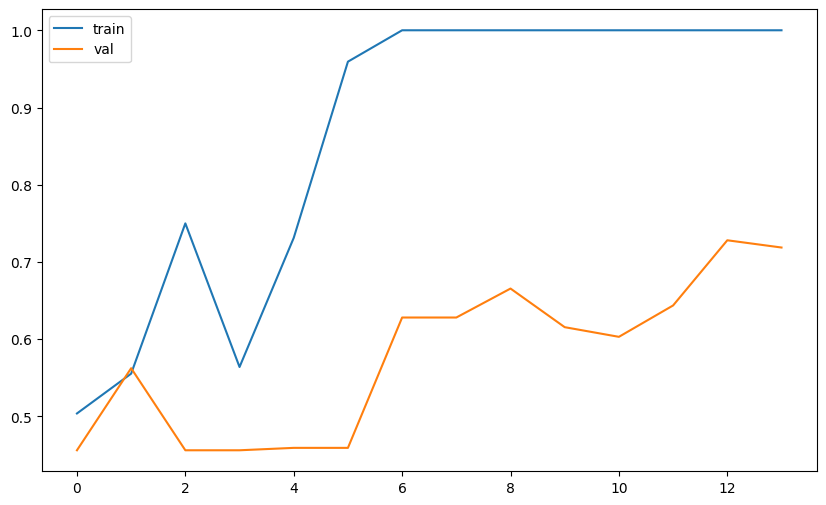

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.7050 - loss: 0.6398
test loss : 0.6397939920425415  test acc : 0.7049999833106995
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


array([[0.6621885],
       [0.6354131]], dtype=float32)

In [5]:
# nltk 데이터로드
import nltk
nltk.download('movie_reviews')
from nltk.corpus import movie_reviews

# 재현성 시드 고정
import random
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# 데이터로딩
ids = movie_reviews.fileids()
reviews = [movie_reviews.raw(id) for id in ids]
categories = [ movie_reviews.categories(id)[0] for id in ids]

# 하이퍼파라메터
max_words = 10000 # 최대단어수
maxlen = 500 # 문서길이
embed_dim = 64 # 임베딩차원
batch_size = 256 # batch_size
epochs = 14 # epoch

# 토큰화 + 시퀀스변화 + 패딩
tokenizer = Tokenizer(num_words=max_words,oov_token='UNK')
tokenizer.fit_on_texts(reviews)
x = tokenizer.texts_to_sequences(reviews)
x = pad_sequences(x,maxlen=maxlen,truncating='post')

# 라벨인코딩
label_map = {'pos':0,'neg':1}
y = np.array([label_map.get(c) for c in categories])
# train/test 분할
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,stratify=y, random_state=42, test_size=0.2)
# 모델구성
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words+1,output_dim=embed_dim,input_length=maxlen),
    tf.keras.layers.Conv1D(128,3,activation='relu'),
    tf.keras.layers.MaxPool1D(),  # 시퀀스의 구간별 특징 요약
    tf.keras.layers.Conv1D(256,3,activation='relu'),
    tf.keras.layers.GlobalMaxPool1D(),  # 전체시퀀스의 평균  시퀀스차원없애고 채널 축만남김(채널에대한평균)    
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid'),
])
# 컴파일
adam =  tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['acc'])
# 콜백(선택)
import tensorflow as  tf
es = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
# 학습
history = model.fit(
    x_train,y_train,epochs=epochs,batch_size=batch_size,validation_split = 0.2
    # ,callbacks=[es]
)

# 학습결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['acc'],label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.show()
# 테스트 평가
test_loss,  test_acc =  model.evaluate(x_test,y_test)
print(f'test loss : {test_loss}  test acc : {test_acc}')

# 임의의 데이터로 예측
sample_texts = [
    "This movie was absolutely fantastic and inspiring",
    "I really disliked the plot and the acting was terrible"
]
x_sample = tokenizer.texts_to_sequences(sample_texts)
x_sample = pad_sequences(x_sample,maxlen=maxlen,truncating='post')
x_sample_predict = model.predict(x_sample)
x_sample_predict

- 개선2 다중 커널 크기 병렬 적용 (TextCNN)
    - 커널 크기 3 5 7 동시에 사용 / 다양한 tri-gram  5-gram  7-gram 포착
    - 병렬로 가야함.

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step - acc: 0.5109 - loss: 0.6977 - val_acc: 0.4563 - val_loss: 0.6967
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step - acc: 0.7430 - loss: 0.6758 - val_acc: 0.5437 - val_loss: 0.6888
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - acc: 0.9195 - loss: 0.6650 - val_acc: 0.4563 - val_loss: 0.6922
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - acc: 0.7523 - loss: 0.6497 - val_acc: 0.4563 - val_loss: 0.6927
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - acc: 0.9961 - loss: 0.6309 - val_acc: 0.5938 - val_loss: 0.6868
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - acc: 1.0000 - loss: 0.6081 - val_acc: 0.7000 - val_loss: 0.6821
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step - acc: 1.0000 - loss: 0.5784 - val_acc: 0.6969 - val_loss: 0.6766
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - acc: 1.0000 - loss: 0.5393 - val_acc: 0.7563 - val_loss: 0.6658
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step - acc: 1.0000 - loss: 

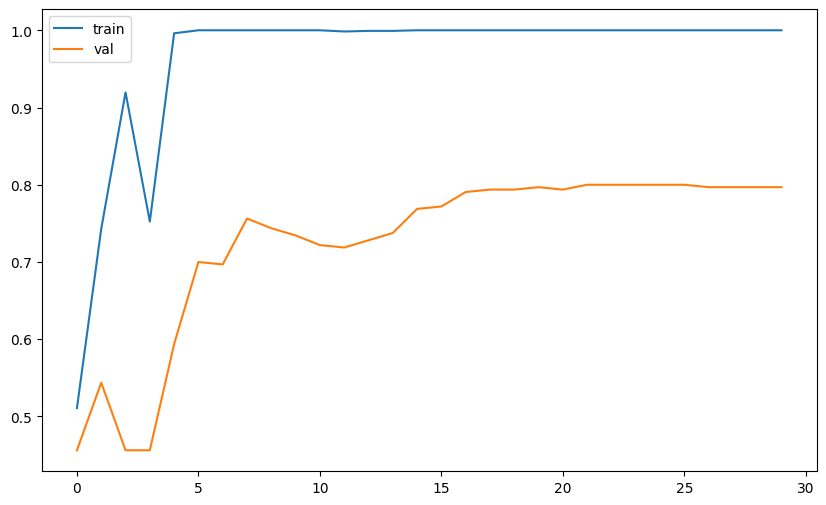

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.7500 - loss: 0.4950
test loss : 0.494989812374115  test acc : 0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


array([[0.4480151 ],
       [0.61426294]], dtype=float32)

In [6]:
from tensorflow.keras.layers import Input, Concatenate
# 입력레이어
input_layer = Input(shape=(maxlen ,) ,dtype='int32')
# 딥러닝에 들어가는 shape 모양은 어떻게 되죠?

# 임베딩 레이어
embedding = tf.keras.layers.Embedding(max_words+1,embed_dim, input_length = maxlen )(input_layer)
conv_blocks = []
for kener_size in [3,5,7]:
    conv = tf.keras.layers.Conv1D(128,kener_size,activation='relu')(embedding)
    pool = tf.keras.layers.GlobalMaxPool1D()(conv)
    conv_blocks.append(pool)
# 병렬 브랜치 결합
concat = Concatenate()(conv_blocks)
# 완전연결층
dense = tf.keras.layers.Dense(64,activation='relu')(concat)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

#모델 생성
model = tf.keras.models.Model(inputs = input_layer, outputs = output)

# 컴파일
adam =  tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['acc'])
# 콜백(선택)
import tensorflow as  tf
es = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
# 학습
history = model.fit(
    x_train,y_train,epochs=30,batch_size=batch_size,validation_split = 0.2
    # ,callbacks=[es]
)

# 학습결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['acc'],label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.show()
# 테스트 평가
test_loss,  test_acc =  model.evaluate(x_test,y_test)
print(f'test loss : {test_loss}  test acc : {test_acc}')

# 임의의 데이터로 예측
sample_texts = [
    "This movie was absolutely fantastic and inspiring",
    "I really disliked the plot and the acting was terrible"
]
x_sample = tokenizer.texts_to_sequences(sample_texts)
x_sample = pad_sequences(x_sample,maxlen=maxlen,truncating='post')
x_sample_predict = model.predict(x_sample)
x_sample_predict

